In [9]:
import numpy as np 
import pandas as pd 
import glob 
import random 
import os 

# 파일 경로 설정 - VSCode 상대경로로 변경
# 실제 경로에 맞게 수정 필요
base_folder =  '/home/user/torch_ubuntu/src/data/ETRI_lifelog_dataset'
folder = '/ch2025_data_items'

data_dir = base_folder + folder 


# Parquet 파일 전체 경로 리스트 
parquet_files = glob.glob(os.path.join(data_dir, 'ch2025_*.parquet')) 

# 파일 이름을 키로, DataFrame을 값으로 저장할 딕셔너리 
lifelog_data = {} 

# 파일별로 읽기 
for file_path in parquet_files: 
    name = os.path.basename(file_path).replace('.parquet', '').replace('ch2025_', '') 
    lifelog_data[name] = pd.read_parquet(file_path) 
    print(f"✅ Loaded: {name}, shape = {lifelog_data[name].shape}") 

# 딕셔너리에 있는 모든 항목을 독립적인 변수로 할당 
for key, df in lifelog_data.items(): 
    globals()[f"{key}_df"] = df 

# 메트릭스 파일 읽기
metrics_train = pd.read_csv(base_folder + '/ch2025_metrics_train.csv')
sample_submission = pd.read_csv(base_folder+'/ch2025_submission_sample.csv')

# ✅ 기준 쌍 (subject_id, lifelog_date) 
sample_submission['lifelog_date'] = pd.to_datetime(sample_submission['lifelog_date']) 
test_keys = set(zip(sample_submission['subject_id'], sample_submission['lifelog_date'].dt.date)) 

# --------------------------- # 
# ✅ DataFrame 별 timestamp 컬럼 수동 지정 
dataframes = { 
    'mACStatus': (mACStatus_df, 'timestamp'), 
    'mActivity': (mActivity_df, 'timestamp'), 
    'mAmbience': (mAmbience_df, 'timestamp'), 
    'mBle': (mBle_df, 'timestamp'), 
    'mGps': (mGps_df, 'timestamp'), 
    'mLight': (mLight_df, 'timestamp'), 
    'mScreenStatus': (mScreenStatus_df, 'timestamp'), 
    'mUsageStats': (mUsageStats_df, 'timestamp'), 
    'mWifi': (mWifi_df, 'timestamp'), 
    'wHr': (wHr_df, 'timestamp'), 
    'wLight': (wLight_df, 'timestamp'), 
    'wPedo': (wPedo_df, 'timestamp'), 
} 


✅ Loaded: mBle, shape = (21830, 3)
✅ Loaded: mAmbience, shape = (476577, 3)
✅ Loaded: mACStatus, shape = (939896, 3)
✅ Loaded: wHr, shape = (382918, 3)
✅ Loaded: mWifi, shape = (76336, 3)
✅ Loaded: mUsageStats, shape = (45197, 3)
✅ Loaded: mActivity, shape = (961062, 3)
✅ Loaded: wLight, shape = (633741, 3)
✅ Loaded: mLight, shape = (96258, 3)
✅ Loaded: mScreenStatus, shape = (939653, 3)
✅ Loaded: mGps, shape = (800611, 3)
✅ Loaded: wPedo, shape = (748100, 9)


In [10]:
# ✅ 분리 함수 
def split_test_train(df, subject_col='subject_id', timestamp_col='timestamp'): 
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce') 
    df = df.dropna(subset=[timestamp_col]) 
    df['date_only'] = df[timestamp_col].dt.date 
    df['key'] = list(zip(df[subject_col], df['date_only'])) 
    test_df = df[df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    train_df = df[~df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    return test_df, train_df 


# ✅ 결과 저장 
for name, (df, ts_col) in dataframes.items(): 
    print(f"⏳ {name} 분리 중...") 
    test_df, train_df = split_test_train(df.copy(), subject_col='subject_id', timestamp_col=ts_col) 
    globals()[f"{name}_test"] = test_df 
    globals()[f"{name}_train"] = train_df 
    print(f"✅ {name}_test → {test_df.shape}, {name}_train → {train_df.shape}") 

⏳ mACStatus 분리 중...
✅ mACStatus_test → (335849, 3), mACStatus_train → (604047, 3)
⏳ mActivity 분리 중...
✅ mActivity_test → (343579, 3), mActivity_train → (617483, 3)
⏳ mAmbience 분리 중...
✅ mAmbience_test → (170453, 3), mAmbience_train → (306124, 3)
⏳ mBle 분리 중...
✅ mBle_test → (8140, 3), mBle_train → (13690, 3)
⏳ mGps 분리 중...
✅ mGps_test → (287386, 3), mGps_train → (513225, 3)
⏳ mLight 분리 중...
✅ mLight_test → (34439, 3), mLight_train → (61819, 3)
⏳ mScreenStatus 분리 중...
✅ mScreenStatus_test → (336160, 3), mScreenStatus_train → (603493, 3)
⏳ mUsageStats 분리 중...
✅ mUsageStats_test → (16499, 3), mUsageStats_train → (28698, 3)
⏳ mWifi 분리 중...
✅ mWifi_test → (27467, 3), mWifi_train → (48869, 3)
⏳ wHr 분리 중...
✅ wHr_test → (143311, 3), wHr_train → (239607, 3)
⏳ wLight 분리 중...
✅ wLight_test → (233809, 3), wLight_train → (399932, 3)
⏳ wPedo 분리 중...
✅ wPedo_test → (288832, 9), wPedo_train → (459268, 9)


### mActivity - Google 활동인식 API에 의해 계산된 값

In [17]:
'''
0: in_vehicle, 
1: on_bicycle, 
2: on_foot, 
3: still, 
4: unknown, 
5: tilting,
7: walking, 
8: running
'''
mActivity_df[mActivity_df['subject_id'] == 'id01'].head(10)


,subject_id,timestamp,m_activity,date
0,id01,2024-06-26 12:03:00,4,2024-06-26
1,id01,2024-06-26 12:04:00,0,2024-06-26
2,id01,2024-06-26 12:05:00,0,2024-06-26
3,id01,2024-06-26 12:06:00,0,2024-06-26
4,id01,2024-06-26 12:07:00,0,2024-06-26
5,id01,2024-06-26 12:08:00,0,2024-06-26
6,id01,2024-06-26 12:09:00,0,2024-06-26
7,id01,2024-06-26 12:10:00,0,2024-06-26
8,id01,2024-06-26 12:11:00,3,2024-06-26
9,id01,2024-06-26 12:12:00,3,2024-06-26


* RAW 데이터 시각화

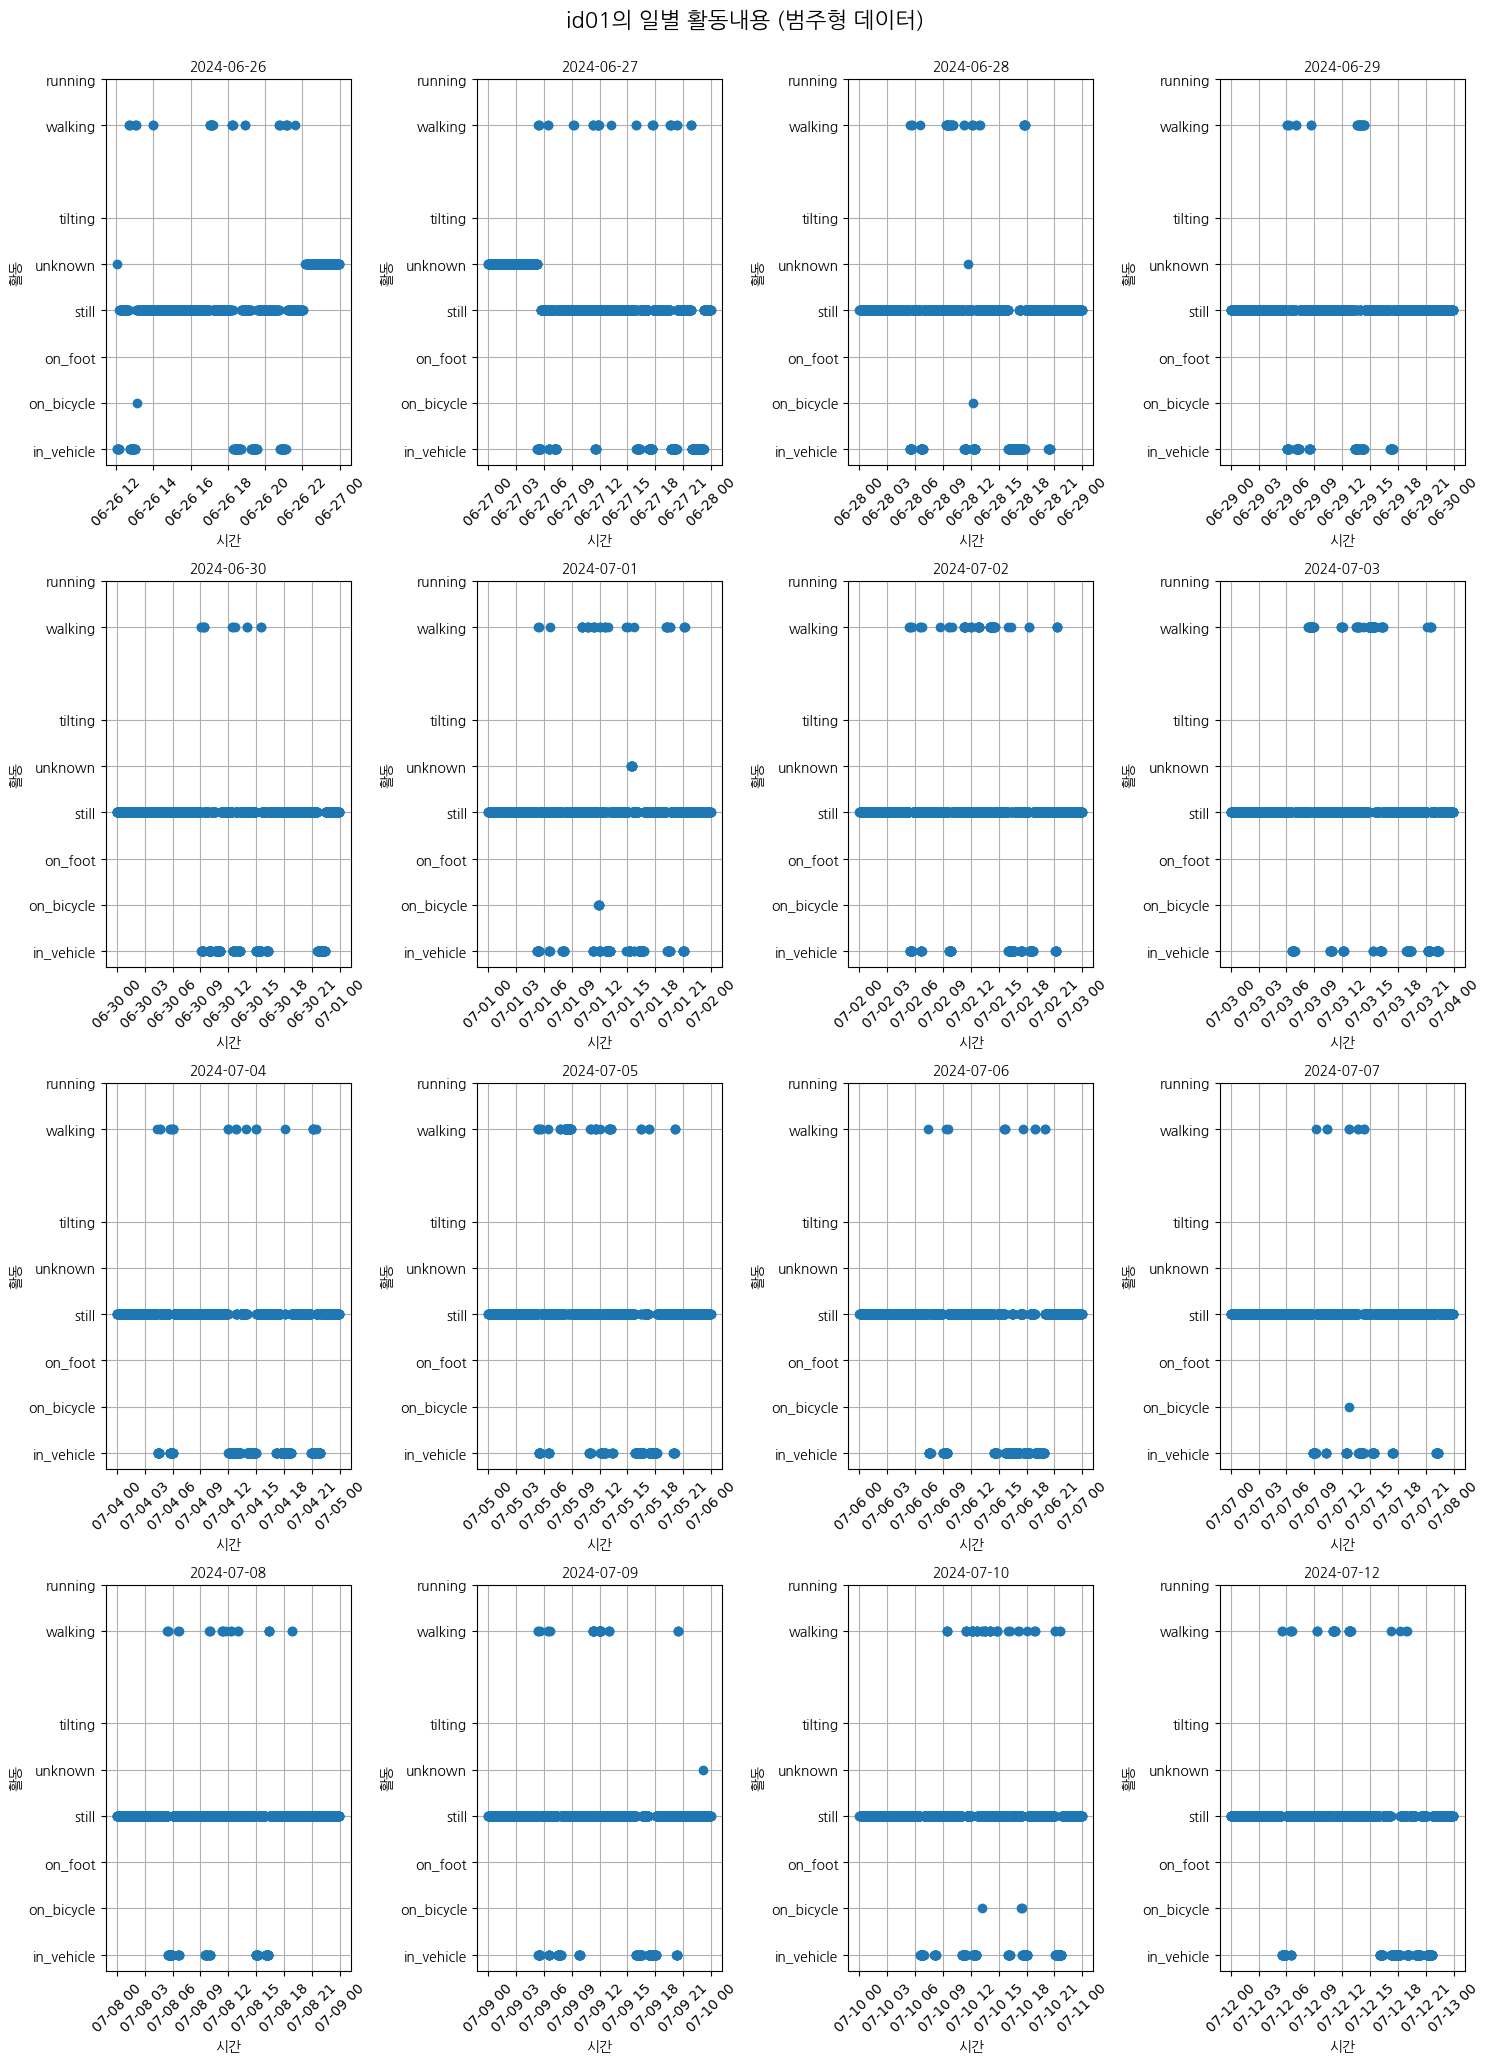

In [34]:
id = "id01"

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔고딕 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)

# m_activity에 대한 레이블 정보
activity_labels = {
    0: 'in_vehicle',
    1: 'on_bicycle',
    2: 'on_foot',
    3: 'still',
    4: 'unknown',
    5: 'tilting',
    7: 'walking',
    8: 'running'
}

# subject_id가 'id01'인 데이터만 필터링
df_id01 = mActivity_df[mActivity_df['subject_id'] == 'id01'].copy()

# timestamp를 datetime 형식으로 변환
df_id01['timestamp'] = pd.to_datetime(df_id01['timestamp'])
df_id01 = df_id01.sort_values(by='timestamp')

# date별로 그룹화
grouped = df_id01.groupby('date')

# 그래프를 그릴 subplot 개수 계산
num_dates = len(grouped)
rows = (num_dates + 3) // 4  # 4개의 그래프씩 최대 rows 행
cols = min(num_dates, 4)      # 최대 4개의 그래프씩 cols 열

# 전체 그래프 크기 설정 (조절 가능)

# 전체 그래프 크기 설정 (조절 가능)
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
fig.suptitle(f'{id}의 일별 활동내용 (범주형 데이터)', fontsize=16, fontproperties=font_prop, y=1.0)   # y 값 조정
plt.subplots_adjust(top=0.9) # top 값 조정
axes = axes.flatten() # 2차원 배열을 1차원으로 평탄화

plot_index = 0
for date, group in grouped:
    if plot_index < 16: # 최대 16개의 그래프만 그리기
        ax = axes[plot_index]
        ax.plot(group['timestamp'], group['m_activity'], marker='o', linestyle='None')
        ax.set_xlabel('시간', fontproperties=font_prop)
        ax.set_ylabel('활동', fontproperties=font_prop)
        ax.set_title(f'{date}', fontproperties=font_prop)
        ax.tick_params(axis='x', rotation=45)
        ax.yaxis.set_ticks(list(activity_labels.keys()))
        ax.yaxis.set_ticklabels([activity_labels.get(x, str(x)) for x in ax.get_yticks()], fontproperties=font_prop)
        ax.grid(True)
        plot_index += 1

# 사용하지 않는 subplot 숨기기
for i in range(plot_index, rows * cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [35]:
def process_mActivity(df): 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    summary = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        counts = group['m_activity'].value_counts(normalize=True) # 비율 
        row = {'subject_id': subj, 'date': date} 
        # 0~8 비율 저장 
        for i in range(9): 
            row[f'activity_{i}_ratio'] = counts.get(i, 0) 
        # 주요 활동 정보 
        row['dominant_activity'] = group['m_activity'].mode()[0] 
        row['num_unique_activities'] = group['m_activity'].nunique() 
        summary.append(row) 
    return pd.DataFrame(summary) 

mActivity_df2 = process_mActivity(mActivity_df) 


mActivity_df2.subject_id.unique()

array(['id01', 'id02', 'id03', 'id04', 'id05', 'id06', 'id07', 'id08',
       'id09', 'id10'], dtype=object)

In [36]:
mActivity_df2[mActivity_df2['subject_id'] == 'id01'].sort_values('date')

# 날짜 별 특정활동i 비율 

,subject_id,date,activity_0_ratio,activity_1_ratio,activity_2_ratio,activity_3_ratio,activity_4_ratio,activity_5_ratio,activity_6_ratio,activity_7_ratio,activity_8_ratio,dominant_activity,num_unique_activities
0,id01,2024-06-26,0.125176,0.001406,0,0.672293,0.157525,0,0,0.043601,0.0,3,5
1,id01,2024-06-27,0.146528,0.000000,0,0.611111,0.220833,0,0,0.021528,0.0,3,4
2,id01,2024-06-28,0.111806,0.000694,0,0.861806,0.000694,0,0,0.025000,0.0,3,5
3,id01,2024-06-29,0.065972,0.000000,0,0.916667,0.000000,0,0,0.017361,0.0,3,3
4,id01,2024-06-30,0.138194,0.000000,0,0.853472,0.000000,0,0,0.008333,0.0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,id01,2024-09-10,0.085032,0.000000,0,0.801827,0.076599,0,0,0.036543,0.0,3,4
64,id01,2024-09-11,0.112578,0.000695,0,0.845726,0.000695,0,0,0.040306,0.0,3,5
65,id01,2024-09-12,0.102817,0.001408,0,0.839437,0.000704,0,0,0.055634,0.0,3,5
66,id01,2024-09-13,0.120833,0.000000,0,0.848611,0.000000,0,0,0.030556,0.0,3,3


* 그래프

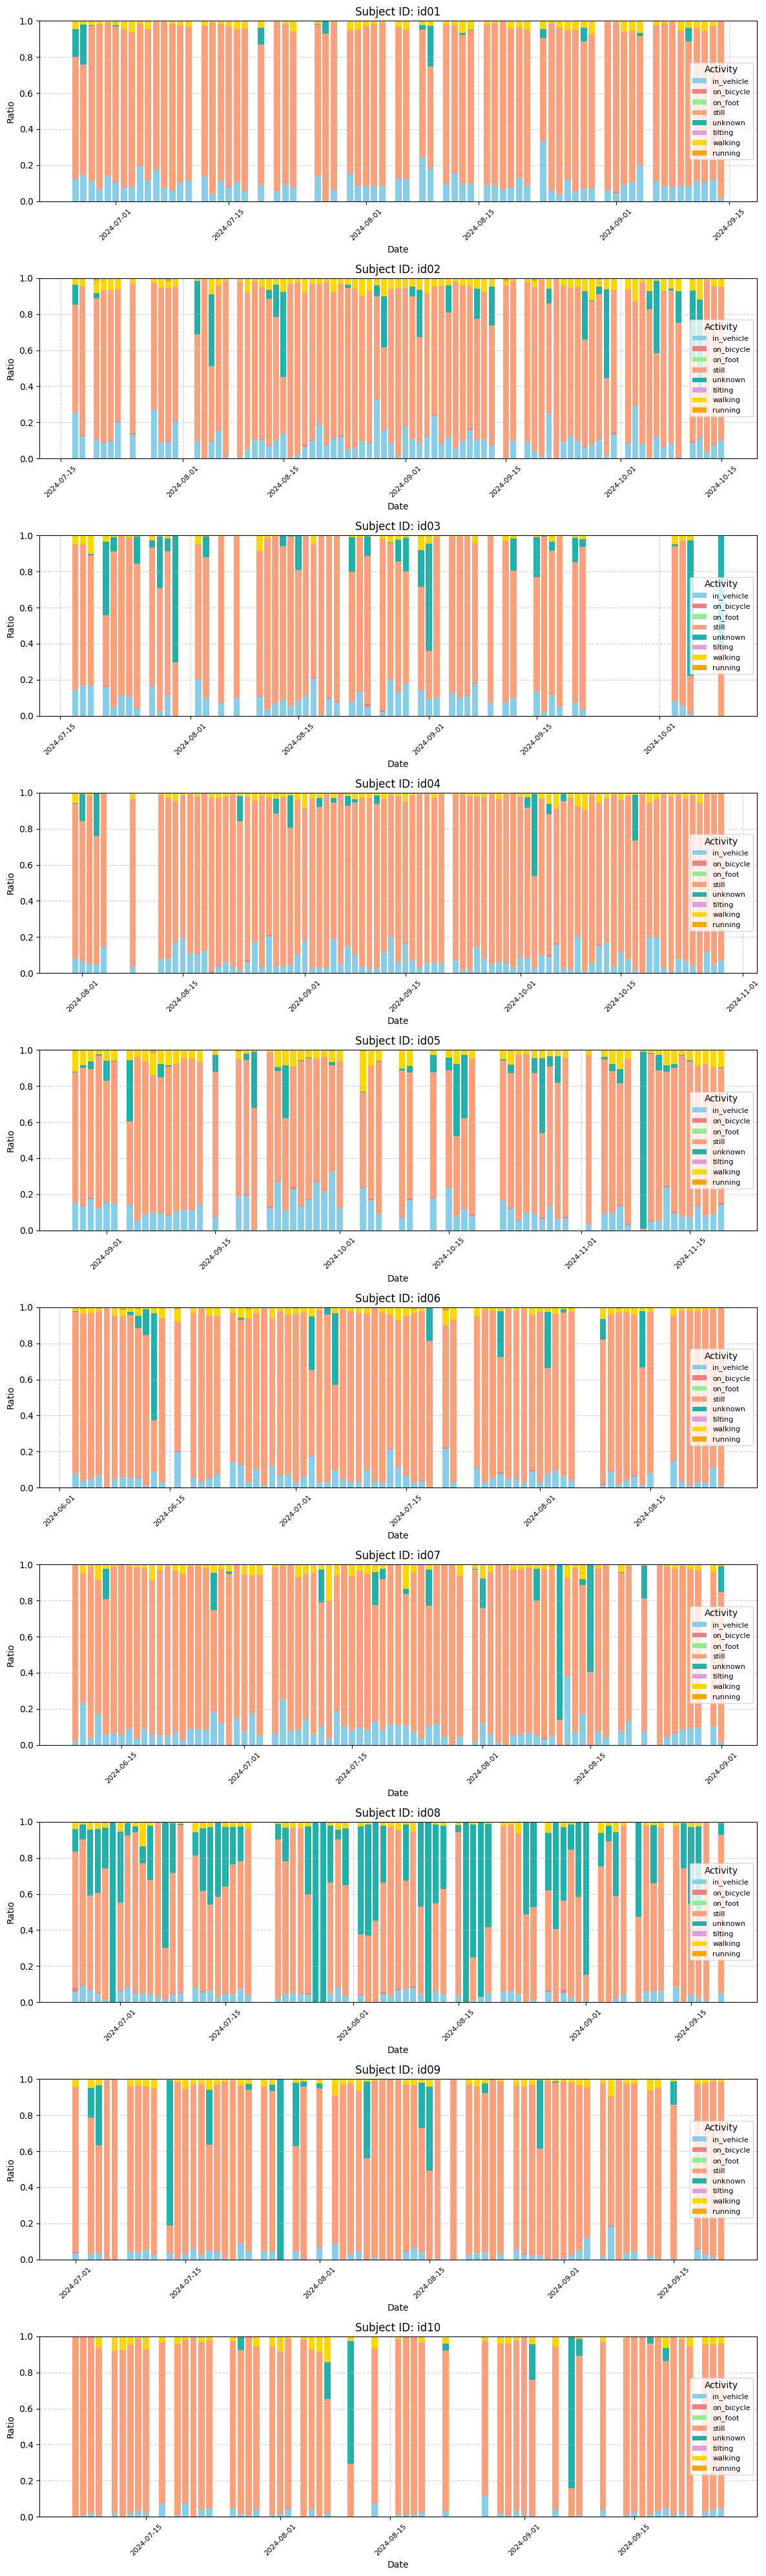

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 활동 이름 매핑 딕셔너리
activity_name_map = {
    0: 'in_vehicle',
    1: 'on_bicycle',
    2: 'on_foot',
    3: 'still',
    4: 'unknown',
    5: 'tilting',
    7: 'walking',
    8: 'running'
}

# 피실험자 ID 목록 추출
subject_ids = mActivity_df2['subject_id'].unique()
num_subjects = len(subject_ids)

# 서브플롯 생성
fig, axes = plt.subplots(num_subjects, 1, figsize=(12, 4 * num_subjects))
if num_subjects == 1:
    axes = [axes]  # 하나의 서브플롯일 경우 axes를 리스트로 감싸줌

# 활동 종류별 색상 지정 (필요에 따라 변경)
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon', 'lightseagreen', 'plum', 'gold', 'orange', 'brown'] # 활동 개수에 맞춰 색상 추가
activity_columns = [col for col in mActivity_df2.columns if col.startswith('activity_') and col != 'activity_6_ratio'] # activity_6_ratio 제외

for i, subject_id in enumerate(subject_ids):
    subject_df = mActivity_df2[mActivity_df2['subject_id'] == subject_id].sort_values(by='date')
    ax = axes[i]

    bottom = [0] * len(subject_df)
    for j, activity in enumerate(activity_columns):
        activity_index = int(activity.split('_')[1]) # 'activity_0' 에서 0 추출
        activity_name = activity_name_map.get(activity_index, f'Activity {activity_index}') # 매핑된 이름이 없으면 기본 이름 사용
        ax.bar(subject_df['date'], subject_df[activity], bottom=bottom, label=activity_name, color=colors[j % len(colors)])
        bottom = [b + v for b, v in zip(bottom, subject_df[activity])]

    ax.set_xlabel('Date')
    ax.set_ylabel('Ratio')
    ax.set_title(f'Subject ID: {subject_id}')
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.legend(title='Activity', fontsize=8, loc='right') # 범례 위치 명시적으로 'right'로 지정
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()